In [1]:
import pandas as pd 
import warnings
import seaborn as sns 
warnings.filterwarnings('ignore')

In [2]:
# read csv
df = pd.read_csv('IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
# split into positive & negative 
positive = df[df['sentiment']=='positive']
negative = df[df['sentiment']=='negative']

In [4]:
# define the number of samples per class for experiment
limit_per_class = 500

# select samples 
pos_l = positive.sample(n = limit_per_class, random_state = 42)
neg_l = negative.sample(n = limit_per_class, random_state = 42)

In [5]:
# archive the full dataframe
archive = df 

df = pd.concat([pos_l, neg_l]).reset_index(drop = True)
df

,review,sentiment
0,I don't know how or why this film has a meager...,positive
1,For a long time it seemed like all the good Ca...,positive
2,Terry Gilliam's and David Peoples' teamed up t...,positive
3,What is there to say about an anti-establishme...,positive
4,This movie was made only 48 years after the en...,positive
...,...,...
995,Do not waste your time watching this! Unless y...,negative
996,This movie just happened to be on HBO yesterda...,negative
997,John Travolta reprises his role as Chili Palme...,negative
998,I am Puerto Rican and this is one of the worst...,negative


<H1> Review Cleaning </H1>

In [6]:
#Replace sentiment with 0 and 1
df['sentiment'].replace({'positive':1,'negative':0},inplace=True)

In [7]:
#Clean reviews
import re
clean = re.compile('<.*?>')
re.sub(clean,'',df.iloc[1].review)
def clean_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean,'',text)
df['review'] = df['review'].apply(clean_html)

#Convert chars to lowercase
def convert_lower(text):
    return text.lower()
df['review'] = df['review'].apply(convert_lower)

#Remove special characters (non-alphanumeric)
def remove_special(text):
    x=''
    for i in text:
        if i.isalnum():
            x=x+i
        else:
            x=x+' '
    return x
df['review'] = df['review'].apply(remove_special)
df.head()

,review,sentiment
0,i don t know how or why this film has a meager...,1
1,for a long time it seemed like all the good ca...,1
2,terry gilliam s and david peoples teamed up t...,1
3,what is there to say about an anti establishme...,1
4,this movie was made only 48 years after the en...,1


In [8]:
from sklearn.model_selection import train_test_split 

# determine X_test & y_test 
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size = 0.2, random_state = 42)

X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

<h1> Experiments </h1>

In [9]:
from sklearn import ensemble
from datetime import datetime
from sklearn.metrics import confusion_matrix, accuracy_score
from sentence_transformers import SentenceTransformer

In [10]:
experiment_name = [] 
experiment_acc = [] 
experiment_time = [] 

<h2> 1. Baseline (BERT Embedding of Original Text + RandomForest Classifier </h2>

In [11]:
# start time 
start = datetime.now()

# Sentence Transformer 
model = SentenceTransformer('bert-base-nli-mean-tokens')

# encode train 
train_encoded = model.encode(X_train.tolist())
dfe_train = pd.DataFrame(train_encoded)
y_train1 = y_train.reset_index(drop = True, inplace = False)
dfe_train['sentiment'] = y_train1

# encode test 
test_encoded = model.encode(X_test.tolist())
dfe_test = pd.DataFrame(test_encoded)
y_test1 = y_test.reset_index(drop = True, inplace = False)
dfe_test['sentiment'] = y_test1

# split into X_train, X_test, y_train, y_test
X_traini = dfe_train.drop(['sentiment'], axis = 1)
y_traini = dfe_train['sentiment']
X_testi = dfe_test.drop(['sentiment'], axis = 1)
y_testi = dfe_test['sentiment']

# random forest classifier 
model_rf = ensemble.RandomForestClassifier(random_state=1)

# train the model 
model_rf.fit(X_traini, y_traini)

# predict sentiment
pred = model_rf.predict(X_testi)

# confusion matrix 
cm_rf = confusion_matrix(y_testi, pred)

# end time 
end = datetime.now()

Accuracy:  0.795
Average Duration (in seconds):  0.209586773


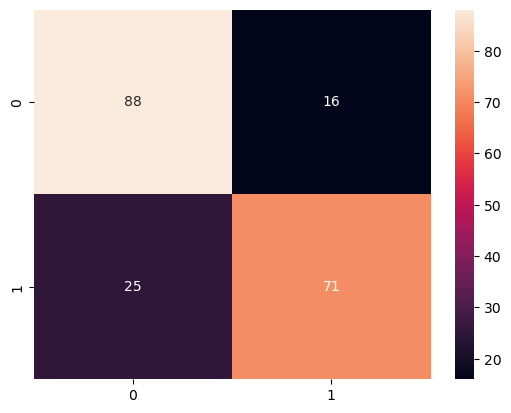

In [12]:
expi_name = "BERT (original text) with RF Classifier"

# print accuracy of model 
acc = accuracy_score(y_testi, pred)
print("Accuracy: ", acc)

# duration of experiment per datapoint 
duration = ((end - start).total_seconds())/len(df)
print("Average Duration (in seconds): ", duration)

# plot confusion matrix using seaborn heatmap 
sns.heatmap(cm_rf, annot=True, fmt="d")

experiment_name.append(expi_name)
experiment_acc.append(acc)
experiment_time.append(duration)

<h2> 2. With Summarization using T5 on Trainset </h2>

Define Summarization Function

In [13]:
from bs4 import BeautifulSoup
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelWithLMHead

def T5_summarization(model, tokenizer, text):
    input_string = f'summarize: {text}'
    input_length = len(text.split())
    
    if input_length > 100:
        max_length = int(0.4 * input_length)
        # min_length = int(0.3 * input_length)
    else: 
        max_length = int(0.9 * input_length) 
        # min_length = int(0.8 * input_length)
    
    inputs =tokenizer.encode(input_string, return_tensors='pt', truncation=True)
    outputs = model.generate(inputs, max_length=max_length)
    summary=tokenizer.decode(outputs[0])

    summary = BeautifulSoup(summary, 'lxml').text
    
    return summary

def summarize(texts):
    
    print('Starting summarization')
    
    tokenizer=AutoTokenizer.from_pretrained('T5-base')
    model=AutoModelWithLMHead.from_pretrained('T5-base', return_dict=True)
    
    result = [] 
    
    for index in tqdm(range(len(texts))): 
        summary = T5_summarization(model, tokenizer, texts[index])
        result.append(summary)
    
    return pd.Series(result)

In [14]:
# start time 
start = datetime.now()

# using T5 to summarize text 
X_train_T5 = summarize(X_train)

# Sentence Transformer 
model = SentenceTransformer('bert-base-nli-mean-tokens')

# encode train 
train_encoded = model.encode(X_train_T5.tolist())
dfe_train = pd.DataFrame(train_encoded)
y_train1 = y_train.reset_index(drop = True, inplace = False)
dfe_train['sentiment'] = y_train1

# encode test 
test_encoded = model.encode(X_test.tolist())
dfe_test = pd.DataFrame(test_encoded)
y_test1 = y_test.reset_index(drop = True, inplace = False)
dfe_test['sentiment'] = y_test1

# split into X_train, X_test, y_train, y_test
X_traini = dfe_train.drop(['sentiment'], axis = 1)
y_traini = dfe_train['sentiment']
X_testi = dfe_test.drop(['sentiment'], axis = 1)
y_testi = dfe_test['sentiment']

# random forest classifier 
model_rf = ensemble.RandomForestClassifier(random_state=1)

# train the model 
model_rf.fit(X_traini, y_traini)

# predict sentiment
pred = model_rf.predict(X_testi)

# confusion matrix 
cm_rf = confusion_matrix(y_testi, pred)

# end time 
end = datetime.now()

Starting summarization


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [46:03<00:00,  3.45s/it]


Accuracy:  0.755
Average Duration (in seconds):  2.8683662340000002


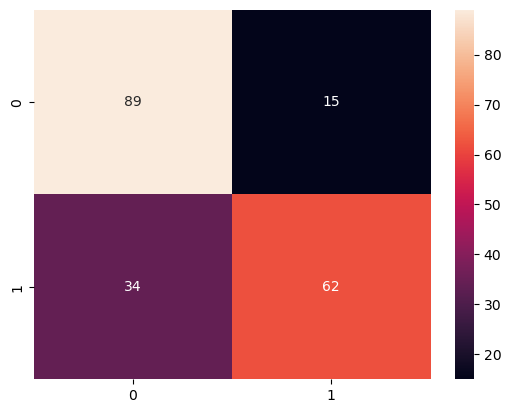

In [15]:
expi_name = "BERT (summarized text) with RF Classifier"

# print accuracy of model 
acc = accuracy_score(y_testi, pred)
print("Accuracy: ", acc)

# duration of experiment per datapoint 
duration = ((end - start).total_seconds())/len(df)
print("Average Duration (in seconds): ", duration)

# plot confusion matrix using seaborn heatmap 
sns.heatmap(cm_rf, annot=True, fmt="d")

experiment_name.append(expi_name)
experiment_acc.append(acc)
experiment_time.append(duration)

<h1> 3. With Expanded Dataset Through Augmentation Techniques </h1>

In [16]:
from textattack.augmentation import WordNetAugmenter, EasyDataAugmenter, CheckListAugmenter
# from textattack.augmentation import WordNetAugmenter, EmbeddingAugmenter, EasyDataAugmenter, CharSwapAugmenter, CheckListAugmenter, BackTranslationAugmenter
from tqdm import tqdm

def easy_aug(X_train):
        
    aug_easydata = EasyDataAugmenter()
    
    processed = [] 
    
    for index in tqdm(range(len(X_train))):
        item = aug_easydata.augment(X_train[index])
        processed.append(item)
    
    return pd.Series(processed)

def wordnet_aug(X_train):
        
    aug_wordnet = WordNetAugmenter()
    
    processed = [] 
    
    for index in tqdm(range(len(X_train))):
        item = aug_wordnet.augment(X_train[index])
        processed.append(item[0])
    
    return pd.Series(processed)

def checklist_aug(X_train):
        
    aug_checklist = CheckListAugmenter()
    
    processed = [] 
    
    for index in tqdm(range(len(X_train))):
        item = aug_checklist.augment(X_train[index])
        processed.append(item[0])
    
    return pd.Series(processed)

In [17]:
def data_augmentation(X_train, y_train, X_train_T5):
    
    target_variable = 'review'
    
    df = pd.DataFrame(X_train_T5, columns = [target_variable])
    df['sentiment'] = y_train    

    # format T5 summary dataframe (x1)
    df1 = df.copy()
    result = df 
    
    # append original 
    df1 = pd.DataFrame(X_train, columns = [target_variable])
    df1['sentiment'] = y_train
    result = pd.concat([result, df1]).reset_index(drop = True)

    # easy data augmenter (explode) (x4)
    print('easy data ...')
    df1 = df.copy()
    processed = easy_aug(df1[target_variable])
    df1[target_variable] = processed
    df1 = df1.explode(target_variable).reset_index(drop = True)
    result = pd.concat([result, df1]).reset_index(drop = True)    
    
    # wordnet augmenter 
    print('wordnet ...')
    df1 = df.copy()
    processed = wordnet_aug(df1[target_variable])
    df1[target_variable] = processed
    result = pd.concat([result, df1]).reset_index(drop = True)
    
    # wordnet augmenter 
    print('checklist ...')
    df1 = df.copy()
    processed = checklist_aug(df1[target_variable])
    df1[target_variable] = processed
    result = pd.concat([result, df1]).reset_index(drop = True)    

    return result

In [18]:
# start time 
start = datetime.now()

# using T5 to summarize text 
train_aug = data_augmentation(X_train, y_train, X_train_T5)

# Sentence Transformer 
model = SentenceTransformer('bert-base-nli-mean-tokens')

# encode train 
train_encoded = model.encode(train_aug['review'].tolist())
dfe_train = pd.DataFrame(train_encoded)
y_train1 = train_aug['sentiment']
dfe_train['sentiment'] = y_train1

# encode test 
test_encoded = model.encode(X_test.tolist())
dfe_test = pd.DataFrame(test_encoded)
y_test1 = y_test.reset_index(drop = True, inplace = False)
dfe_test['sentiment'] = y_test1

# split into X_train, X_test, y_train, y_test
X_traini = dfe_train.drop(['sentiment'], axis = 1)
y_traini = dfe_train['sentiment']
X_testi = dfe_test.drop(['sentiment'], axis = 1)
y_testi = dfe_test['sentiment']

# random forest classifier 
model_rf = ensemble.RandomForestClassifier(random_state=1)

# train the model 
model_rf.fit(X_traini, y_traini)

# predict sentiment
pred = model_rf.predict(X_testi)

# confusion matrix 
cm_rf = confusion_matrix(y_testi, pred)

# end time 
end = datetime.now()

easy data ...


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [11:41<00:00,  1.14it/s]
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


wordnet ...


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [07:45<00:00,  1.72it/s]


checklist ...


  0%|                                                                                          | 0/800 [00:00<?, ?it/s]

2023-11-10 21:54:55,943 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [49:16<00:00,  3.70s/it]


Accuracy:  0.8
Average Duration (in seconds):  4.927538008000001
Shape of dfe_train:  (6400, 769)


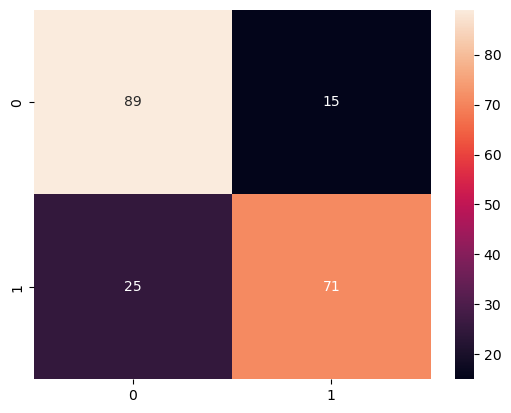

In [19]:
expi_name = "BERT (Augment text) with RF Classifier"

# print accuracy of model 
acc = accuracy_score(y_testi, pred)
print("Accuracy: ", acc)

# duration of experiment per datapoint 
duration = ((end - start).total_seconds())/len(df)
print("Average Duration (in seconds): ", duration)

# print shape of dfe_train 
print("Shape of dfe_train: ", dfe_train.shape)

# plot confusion matrix using seaborn heatmap 
sns.heatmap(cm_rf, annot=True, fmt="d")

experiment_name.append(expi_name)
experiment_acc.append(acc)
experiment_time.append(duration)

<h1> Consolidation of Performance </h1>

In [20]:
result_df = pd.DataFrame()

result_df['Experiment Name'] = experiment_name 
result_df['Experiment Accuracy'] = experiment_acc 
result_df['Avg Experiment Time per Datapoint'] = experiment_time 

# show dataframe 
result_df

,Experiment Name,Experiment Accuracy,Avg Experiment Time per Datapoint
0,BERT (original text) with RF Classifier,0.795,0.209587
1,BERT (summarized text) with RF Classifier,0.755,2.868366
2,BERT (Augment text) with RF Classifier,0.800,4.927538


<b> Example of T5 Summarized Text </b>

In [21]:
X_train_T5[2]

" author steven greenstreet has been a big fan of michael moore. moore was paid 40 000 of the state of utah's educational funds to promote his own liberal movie. greenstreet has even dropped out of film school to help accelerate his career."

In [22]:
X_train[2]

'not only does the film s author  steven greenstreet  obviously idolize michael moore  but he also follows in his footsteps by using several of moore s propaganda film making tactics  moore has expertise in distracting the viewer from this focus though  while greenstreet is obviously less skilled here having been privy to all of the issues surrounding moore s speech at uvsc  i was disappointed to see that the major complaints of the community    that moore was being paid  40 000 of the state of utah  s educational funds to basically promote john kerry s campaign and to advertise his own liberal movie    were pushed to the background by greenstreet while lesser issues were sensationalized the marketing methods for this video have been equally biased and objectionable    promoting the film by claiming that  mormon s tried to kill moore   not only is this preposterous  but it defames a major religion that greenstreet obviously has some personal issues with  i followed moore s visit very c

<b> Visualization of T5 Summarized Text Word Count Distribution </b>

In [23]:
import seaborn as sns 
import matplotlib.pyplot as plt

original = [] 
summarized = [] 

for review in X_train: 
    original.append(len(review.split()))

for review in X_train_T5: 
    summarized.append(len(review.split()))

Text(0, 0.5, '')

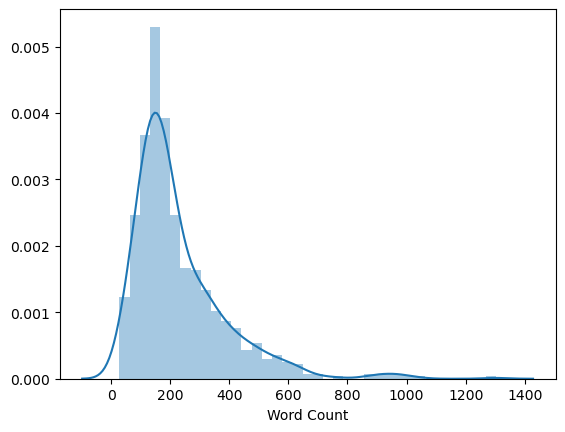

In [24]:
sns.distplot(original)
plt.xlabel('Word Count')
plt.ylabel('')

Text(0.5, 0, 'Word Count')

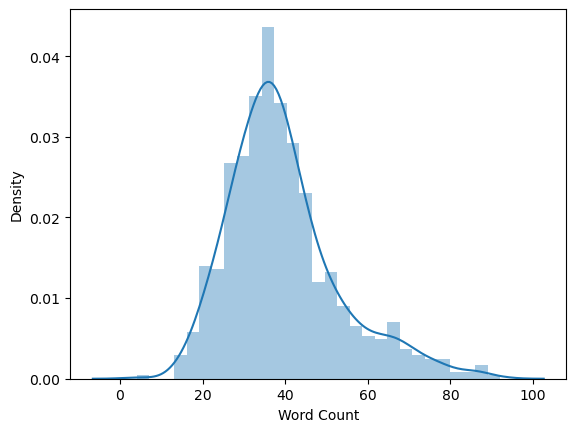

In [25]:
sns.distplot(summarized)
plt.xlabel('Word Count')